CSC with a Spatial Mask
=======================

This example demonstrates the use of [cbpdn.AddMaskSim](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.AddMaskSim) for convolutional sparse coding with a spatial mask [[29]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2016-boundary). The example problem is inpainting of randomly distributed corruption of a greyscale image.

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco.admm import tvl2
from sporco.admm import cbpdn
from sporco import util
from sporco import metric
from sporco import plot
plot.config_notebook_plotting()

Load a reference image.

In [2]:
img = util.ExampleImages().image('monarch.png', zoom=0.5, scaled=True,
                                 gray=True, idxexp=np.s_[:, 160:672])

Create random mask and apply to reference image to obtain test image. (The call to ``numpy.random.seed`` ensures that the pseudo-random noise is reproducible.)

In [3]:
t = 0.5
np.random.seed(12345)
msk = np.random.randn(*(img.shape))
msk[np.abs(msk) > t] = 1;
msk[np.abs(msk) < t] = 0;
imgw = msk * img

Define pad and crop functions.

In [4]:
pn = 8
spad = lambda x:  np.pad(x, pn, mode='symmetric')
zpad = lambda x:  np.pad(x, pn, mode='constant')
crop = lambda x: x[pn:-pn, pn:-pn]

Construct padded mask and test image.

In [5]:
mskp = zpad(msk)
imgwp = spad(imgw)

$\ell_2$-TV denoising with a spatial mask as a non-linear lowpass filter. The highpass component is the difference between the test image and the lowpass component, multiplied by the mask for faster convergence of the convolutional sparse coding (see [[39]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2017-convolutional3)).

In [6]:
lmbda = 0.05
opt = tvl2.TVL2Denoise.Options({'Verbose': False, 'MaxMainIter': 200,
                    'DFidWeight': mskp, 'gEvalY': False,
                    'AutoRho': {'Enabled': True}})
b = tvl2.TVL2Denoise(imgwp, lmbda, opt)
sl = b.solve()
sh = mskp * (imgwp - sl)

Load dictionary.

In [7]:
D = util.convdicts()['G:8x8x128']

Set up [admm.cbpdn.ConvBPDN](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDN) options.

In [8]:
lmbda = 2e-2
opt = cbpdn.ConvBPDN.Options({'Verbose': True, 'MaxMainIter': 200,
                    'HighMemSolve': True, 'RelStopTol': 5e-3,
                    'AuxVarObj': False, 'RelaxParam': 1.8,
                    'rho': 5e1*lmbda + 1e-1, 'AutoRho': {'Enabled': False,
                    'StdResiduals': False}})

Construct [admm.cbpdn.AddMaskSim](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.AddMaskSim) wrapper for [admm.cbpdn.ConvBPDN](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDN) and solve via wrapper. This example could also have made use of [admm.cbpdn.ConvBPDNMaskDcpl](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDNMaskDcpl) (see example `cbpdn_md_gry`), which has similar performance in this application, but [admm.cbpdn.AddMaskSim](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.AddMaskSim) has the advantage of greater flexibility in that the wrapper can be applied to a variety of CSC solver objects.

In [9]:
ams = cbpdn.AddMaskSim(cbpdn.ConvBPDN, D, sh, mskp, lmbda, opt=opt)
X = ams.solve()

Itn   Fnc       DFid      Regℓ1     r         s         
------------------------------------------------------


   0  3.05e+01  4.49e-02  1.52e+03  9.95e-01  1.71e-01


   1  2.68e+01  2.36e-01  1.33e+03  8.21e-01  2.07e-01


   2  2.50e+01  3.84e-01  1.23e+03  4.67e-01  1.78e-01


   3  2.39e+01  4.71e-01  1.17e+03  3.11e-01  1.46e-01


   4  2.33e+01  5.28e-01  1.14e+03  2.34e-01  1.21e-01


   5  2.29e+01  5.71e-01  1.11e+03  1.91e-01  1.02e-01


   6  2.26e+01  6.09e-01  1.10e+03  1.63e-01  8.89e-02


   7  2.24e+01  6.42e-01  1.09e+03  1.44e-01  7.83e-02


   8  2.22e+01  6.72e-01  1.08e+03  1.30e-01  6.94e-02


   9  2.21e+01  7.02e-01  1.07e+03  1.20e-01  6.24e-02


  10  2.18e+01  7.32e-01  1.06e+03  1.12e-01  5.72e-02


  11  2.15e+01  7.62e-01  1.04e+03  1.05e-01  5.38e-02


  12  2.11e+01  7.90e-01  1.02e+03  9.94e-02  5.13e-02


  13  2.08e+01  8.17e-01  9.98e+02  9.46e-02  4.93e-02


  14  2.05e+01  8.41e-01  9.81e+02  9.06e-02  4.76e-02


  15  2.02e+01  8.63e-01  9.65e+02  8.69e-02  4.61e-02


  16  1.99e+01  8.83e-01  9.51e+02  8.36e-02  4.46e-02


  17  1.97e+01  9.02e-01  9.38e+02  8.06e-02  4.32e-02


  18  1.95e+01  9.20e-01  9.27e+02  7.78e-02  4.16e-02


  19  1.93e+01  9.39e-01  9.17e+02  7.52e-02  4.00e-02


  20  1.91e+01  9.57e-01  9.06e+02  7.28e-02  3.83e-02


  21  1.88e+01  9.76e-01  8.93e+02  7.03e-02  3.66e-02


  22  1.85e+01  9.96e-01  8.76e+02  6.80e-02  3.50e-02


  23  1.81e+01  1.02e+00  8.56e+02  6.56e-02  3.37e-02


  24  1.77e+01  1.04e+00  8.35e+02  6.33e-02  3.26e-02


  25  1.74e+01  1.06e+00  8.15e+02  6.12e-02  3.15e-02


  26  1.70e+01  1.08e+00  7.97e+02  5.91e-02  3.03e-02


  27  1.67e+01  1.10e+00  7.80e+02  5.71e-02  2.90e-02


  28  1.64e+01  1.12e+00  7.66e+02  5.52e-02  2.78e-02


  29  1.62e+01  1.13e+00  7.52e+02  5.34e-02  2.67e-02


  30  1.60e+01  1.15e+00  7.40e+02  5.17e-02  2.56e-02


  31  1.57e+01  1.17e+00  7.28e+02  5.01e-02  2.47e-02


  32  1.55e+01  1.18e+00  7.18e+02  4.85e-02  2.39e-02


  33  1.53e+01  1.19e+00  7.07e+02  4.70e-02  2.31e-02


  34  1.52e+01  1.21e+00  6.98e+02  4.56e-02  2.24e-02


  35  1.50e+01  1.22e+00  6.89e+02  4.43e-02  2.18e-02


  36  1.48e+01  1.23e+00  6.81e+02  4.31e-02  2.11e-02


  37  1.47e+01  1.24e+00  6.73e+02  4.19e-02  2.05e-02


  38  1.46e+01  1.25e+00  6.65e+02  4.08e-02  1.99e-02


  39  1.44e+01  1.26e+00  6.57e+02  3.97e-02  1.94e-02


  40  1.42e+01  1.27e+00  6.48e+02  3.87e-02  1.89e-02


  41  1.41e+01  1.28e+00  6.40e+02  3.77e-02  1.85e-02


  42  1.39e+01  1.28e+00  6.32e+02  3.68e-02  1.80e-02


  43  1.38e+01  1.29e+00  6.24e+02  3.59e-02  1.76e-02


  44  1.36e+01  1.30e+00  6.17e+02  3.50e-02  1.71e-02


  45  1.35e+01  1.31e+00  6.10e+02  3.42e-02  1.66e-02


  46  1.34e+01  1.31e+00  6.04e+02  3.34e-02  1.62e-02


  47  1.33e+01  1.32e+00  5.98e+02  3.26e-02  1.57e-02


  48  1.32e+01  1.33e+00  5.93e+02  3.19e-02  1.53e-02


  49  1.31e+01  1.33e+00  5.88e+02  3.12e-02  1.49e-02


  50  1.30e+01  1.34e+00  5.83e+02  3.04e-02  1.45e-02


  51  1.29e+01  1.34e+00  5.79e+02  2.98e-02  1.42e-02


  52  1.28e+01  1.35e+00  5.74e+02  2.91e-02  1.38e-02


  53  1.27e+01  1.35e+00  5.69e+02  2.85e-02  1.35e-02


  54  1.27e+01  1.36e+00  5.65e+02  2.78e-02  1.32e-02


  55  1.26e+01  1.36e+00  5.60e+02  2.73e-02  1.29e-02


  56  1.25e+01  1.36e+00  5.56e+02  2.67e-02  1.27e-02


  57  1.24e+01  1.37e+00  5.51e+02  2.61e-02  1.24e-02


  58  1.23e+01  1.37e+00  5.46e+02  2.56e-02  1.22e-02


  59  1.22e+01  1.37e+00  5.41e+02  2.51e-02  1.20e-02


  60  1.21e+01  1.38e+00  5.36e+02  2.46e-02  1.17e-02


  61  1.20e+01  1.38e+00  5.32e+02  2.41e-02  1.15e-02


  62  1.19e+01  1.38e+00  5.28e+02  2.36e-02  1.12e-02


  63  1.19e+01  1.39e+00  5.24e+02  2.32e-02  1.10e-02


  64  1.18e+01  1.39e+00  5.21e+02  2.28e-02  1.07e-02


  65  1.17e+01  1.39e+00  5.17e+02  2.24e-02  1.05e-02


  66  1.17e+01  1.40e+00  5.14e+02  2.20e-02  1.03e-02


  67  1.16e+01  1.40e+00  5.10e+02  2.16e-02  1.00e-02


  68  1.15e+01  1.40e+00  5.06e+02  2.12e-02  9.84e-03


  69  1.15e+01  1.41e+00  5.03e+02  2.08e-02  9.67e-03


  70  1.14e+01  1.41e+00  4.99e+02  2.05e-02  9.49e-03


  71  1.13e+01  1.41e+00  4.95e+02  2.01e-02  9.33e-03


  72  1.13e+01  1.42e+00  4.92e+02  1.97e-02  9.17e-03


  73  1.12e+01  1.42e+00  4.89e+02  1.94e-02  9.02e-03


  74  1.11e+01  1.42e+00  4.85e+02  1.90e-02  8.87e-03


  75  1.11e+01  1.42e+00  4.82e+02  1.87e-02  8.71e-03


  76  1.10e+01  1.43e+00  4.79e+02  1.84e-02  8.56e-03


  77  1.10e+01  1.43e+00  4.77e+02  1.81e-02  8.41e-03


  78  1.09e+01  1.43e+00  4.74e+02  1.78e-02  8.27e-03


  79  1.09e+01  1.43e+00  4.71e+02  1.75e-02  8.12e-03


  80  1.08e+01  1.44e+00  4.68e+02  1.72e-02  7.98e-03


  81  1.07e+01  1.44e+00  4.65e+02  1.69e-02  7.83e-03


  82  1.07e+01  1.44e+00  4.63e+02  1.66e-02  7.70e-03


  83  1.06e+01  1.44e+00  4.60e+02  1.64e-02  7.55e-03


  84  1.06e+01  1.45e+00  4.58e+02  1.61e-02  7.42e-03


  85  1.06e+01  1.45e+00  4.56e+02  1.59e-02  7.28e-03


  86  1.05e+01  1.45e+00  4.54e+02  1.56e-02  7.15e-03


  87  1.05e+01  1.45e+00  4.51e+02  1.54e-02  7.01e-03


  88  1.04e+01  1.45e+00  4.49e+02  1.51e-02  6.89e-03


  89  1.04e+01  1.46e+00  4.47e+02  1.49e-02  6.77e-03


  90  1.04e+01  1.46e+00  4.45e+02  1.47e-02  6.66e-03


  91  1.03e+01  1.46e+00  4.44e+02  1.44e-02  6.55e-03


  92  1.03e+01  1.46e+00  4.42e+02  1.42e-02  6.45e-03


  93  1.03e+01  1.46e+00  4.40e+02  1.40e-02  6.35e-03


  94  1.02e+01  1.47e+00  4.38e+02  1.38e-02  6.24e-03


  95  1.02e+01  1.47e+00  4.36e+02  1.36e-02  6.15e-03


  96  1.02e+01  1.47e+00  4.35e+02  1.34e-02  6.05e-03


  97  1.01e+01  1.47e+00  4.33e+02  1.32e-02  5.95e-03


  98  1.01e+01  1.47e+00  4.31e+02  1.30e-02  5.86e-03


  99  1.01e+01  1.47e+00  4.29e+02  1.28e-02  5.77e-03


 100  1.00e+01  1.47e+00  4.27e+02  1.26e-02  5.68e-03


 101  9.99e+00  1.48e+00  4.26e+02  1.24e-02  5.60e-03


 102  9.96e+00  1.48e+00  4.24e+02  1.23e-02  5.51e-03


 103  9.93e+00  1.48e+00  4.22e+02  1.21e-02  5.42e-03


 104  9.90e+00  1.48e+00  4.21e+02  1.19e-02  5.34e-03


 105  9.87e+00  1.48e+00  4.19e+02  1.17e-02  5.26e-03


 106  9.84e+00  1.48e+00  4.18e+02  1.16e-02  5.18e-03


 107  9.81e+00  1.48e+00  4.16e+02  1.14e-02  5.10e-03


 108  9.78e+00  1.49e+00  4.15e+02  1.12e-02  5.03e-03


 109  9.75e+00  1.49e+00  4.13e+02  1.11e-02  4.96e-03


 110  9.72e+00  1.49e+00  4.12e+02  1.09e-02  4.89e-03


 111  9.69e+00  1.49e+00  4.10e+02  1.08e-02  4.83e-03


 112  9.66e+00  1.49e+00  4.09e+02  1.06e-02  4.76e-03


 113  9.64e+00  1.49e+00  4.07e+02  1.05e-02  4.70e-03


 114  9.61e+00  1.49e+00  4.06e+02  1.03e-02  4.64e-03


 115  9.59e+00  1.49e+00  4.05e+02  1.02e-02  4.57e-03


 116  9.56e+00  1.49e+00  4.03e+02  1.00e-02  4.51e-03


 117  9.54e+00  1.50e+00  4.02e+02  9.89e-03  4.44e-03


 118  9.51e+00  1.50e+00  4.01e+02  9.76e-03  4.38e-03


 119  9.49e+00  1.50e+00  4.00e+02  9.63e-03  4.32e-03


 120  9.47e+00  1.50e+00  3.99e+02  9.50e-03  4.26e-03


 121  9.45e+00  1.50e+00  3.97e+02  9.38e-03  4.20e-03


 122  9.42e+00  1.50e+00  3.96e+02  9.26e-03  4.14e-03


 123  9.40e+00  1.50e+00  3.95e+02  9.14e-03  4.08e-03


 124  9.38e+00  1.50e+00  3.94e+02  9.02e-03  4.02e-03


 125  9.36e+00  1.50e+00  3.93e+02  8.90e-03  3.96e-03


 126  9.34e+00  1.50e+00  3.92e+02  8.79e-03  3.90e-03


 127  9.32e+00  1.50e+00  3.91e+02  8.68e-03  3.84e-03


 128  9.30e+00  1.50e+00  3.90e+02  8.57e-03  3.79e-03


 129  9.28e+00  1.51e+00  3.89e+02  8.46e-03  3.74e-03


 130  9.25e+00  1.51e+00  3.87e+02  8.35e-03  3.69e-03


 131  9.23e+00  1.51e+00  3.86e+02  8.24e-03  3.64e-03


 132  9.21e+00  1.51e+00  3.85e+02  8.14e-03  3.60e-03


 133  9.19e+00  1.51e+00  3.84e+02  8.03e-03  3.55e-03


 134  9.17e+00  1.51e+00  3.83e+02  7.93e-03  3.51e-03


 135  9.15e+00  1.51e+00  3.82e+02  7.83e-03  3.46e-03


 136  9.14e+00  1.51e+00  3.81e+02  7.73e-03  3.42e-03


 137  9.12e+00  1.51e+00  3.80e+02  7.63e-03  3.37e-03


 138  9.10e+00  1.51e+00  3.79e+02  7.54e-03  3.33e-03


 139  9.09e+00  1.51e+00  3.79e+02  7.45e-03  3.28e-03


 140  9.07e+00  1.52e+00  3.78e+02  7.36e-03  3.24e-03


 141  9.05e+00  1.52e+00  3.77e+02  7.27e-03  3.20e-03


 142  9.04e+00  1.52e+00  3.76e+02  7.18e-03  3.16e-03


 143  9.02e+00  1.52e+00  3.75e+02  7.09e-03  3.12e-03


 144  9.00e+00  1.52e+00  3.74e+02  7.00e-03  3.09e-03


 145  8.99e+00  1.52e+00  3.73e+02  6.92e-03  3.05e-03


 146  8.97e+00  1.52e+00  3.72e+02  6.84e-03  3.02e-03


 147  8.95e+00  1.52e+00  3.72e+02  6.75e-03  2.99e-03


 148  8.94e+00  1.52e+00  3.71e+02  6.67e-03  2.95e-03


 149  8.92e+00  1.52e+00  3.70e+02  6.59e-03  2.92e-03


 150  8.91e+00  1.52e+00  3.69e+02  6.52e-03  2.88e-03


 151  8.89e+00  1.52e+00  3.69e+02  6.44e-03  2.85e-03


 152  8.88e+00  1.52e+00  3.68e+02  6.37e-03  2.81e-03


 153  8.87e+00  1.52e+00  3.67e+02  6.29e-03  2.77e-03


 154  8.86e+00  1.52e+00  3.67e+02  6.22e-03  2.74e-03


 155  8.84e+00  1.53e+00  3.66e+02  6.15e-03  2.70e-03


 156  8.83e+00  1.53e+00  3.65e+02  6.08e-03  2.67e-03


 157  8.82e+00  1.53e+00  3.65e+02  6.01e-03  2.63e-03


 158  8.81e+00  1.53e+00  3.64e+02  5.94e-03  2.60e-03


 159  8.79e+00  1.53e+00  3.63e+02  5.87e-03  2.57e-03


 160  8.78e+00  1.53e+00  3.63e+02  5.80e-03  2.54e-03


 161  8.77e+00  1.53e+00  3.62e+02  5.74e-03  2.51e-03


 162  8.75e+00  1.53e+00  3.61e+02  5.67e-03  2.49e-03


 163  8.74e+00  1.53e+00  3.61e+02  5.61e-03  2.46e-03


 164  8.73e+00  1.53e+00  3.60e+02  5.54e-03  2.44e-03


 165  8.71e+00  1.53e+00  3.59e+02  5.48e-03  2.41e-03


 166  8.70e+00  1.53e+00  3.59e+02  5.42e-03  2.39e-03


 167  8.69e+00  1.53e+00  3.58e+02  5.36e-03  2.36e-03


 168  8.68e+00  1.53e+00  3.57e+02  5.30e-03  2.33e-03


 169  8.67e+00  1.53e+00  3.57e+02  5.25e-03  2.30e-03


 170  8.66e+00  1.53e+00  3.56e+02  5.19e-03  2.27e-03


 171  8.65e+00  1.53e+00  3.56e+02  5.14e-03  2.24e-03


 172  8.64e+00  1.53e+00  3.55e+02  5.09e-03  2.21e-03


 173  8.63e+00  1.53e+00  3.55e+02  5.03e-03  2.18e-03


 174  8.62e+00  1.53e+00  3.55e+02  4.98e-03  2.15e-03
------------------------------------------------------


Reconstruct from representation.

In [10]:
imgr = crop(sl + ams.reconstruct().squeeze())

Display solve time and reconstruction performance.

In [11]:
print("AddMaskSim wrapped ConvBPDN solve time: %.2fs" %
      ams.timer.elapsed('solve'))
print("Corrupted image PSNR: %5.2f dB" % metric.psnr(img, imgw))
print("Recovered image PSNR: %5.2f dB" % metric.psnr(img, imgr))

AddMaskSim wrapped ConvBPDN solve time: 150.96s
Corrupted image PSNR: 10.33 dB
Recovered image PSNR: 26.66 dB


Display reference, test, and reconstructed image

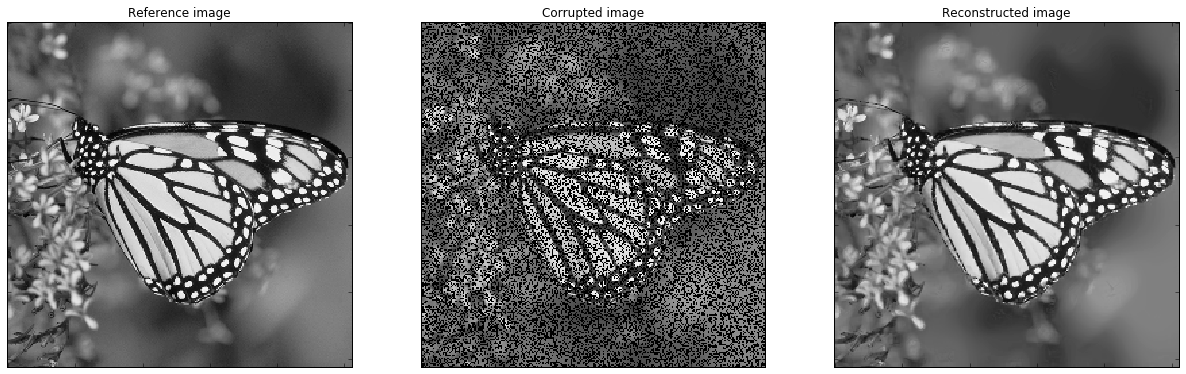

In [12]:
fig = plot.figure(figsize=(21, 7))
plot.subplot(1, 3, 1)
plot.imview(img, fgrf=fig, title='Reference image')
plot.subplot(1, 3, 2)
plot.imview(imgw, fgrf=fig, title='Corrupted image')
plot.subplot(1, 3, 3)
plot.imview(imgr, fgrf=fig, title='Reconstructed image')
fig.show()

Display lowpass component and sparse representation

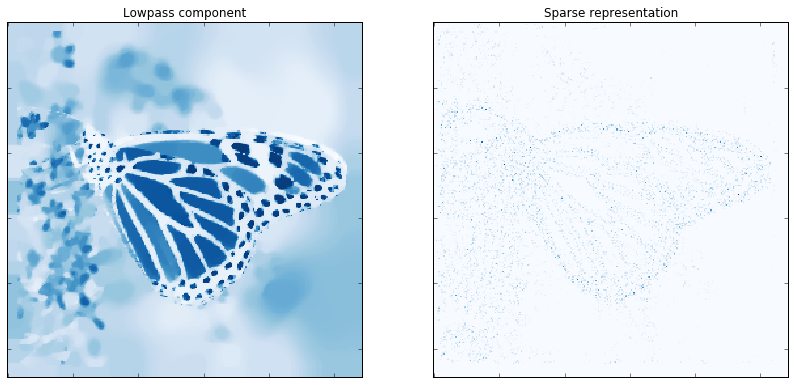

In [13]:
fig = plot.figure(figsize=(14, 7))
plot.subplot(1, 2, 1)
plot.imview(sl, fgrf=fig, cmap=plot.cm.Blues, title='Lowpass component')
plot.subplot(1, 2, 2)
plot.imview(np.squeeze(np.sum(abs(X), axis=ams.cri.axisM)), fgrf=fig,
            cmap=plot.cm.Blues, title='Sparse representation')
fig.show()

Plot functional value, residuals, and rho

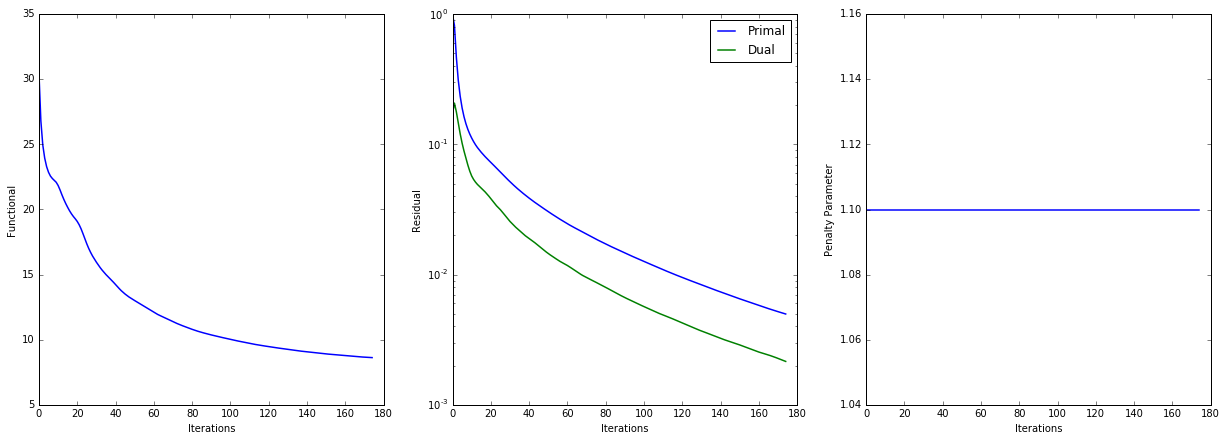

In [14]:
its = ams.getitstat()
fig = plot.figure(figsize=(21, 7))
plot.subplot(1, 3, 1)
plot.plot(its.ObjFun, fgrf=fig, xlbl='Iterations', ylbl='Functional')
plot.subplot(1, 3, 2)
plot.plot(np.vstack((its.PrimalRsdl, its.DualRsdl)).T, fgrf=fig,
          ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          lgnd=['Primal', 'Dual'])
plot.subplot(1, 3, 3)
plot.plot(its.Rho, fgrf=fig, xlbl='Iterations', ylbl='Penalty Parameter')
fig.show()